In [1]:
import os
import torch
from DataReader import load_data, train_vaild_split
from Model import Cifar

def run_experiment(batch_size, save_interval, weight_decay, learning_rate, modeldir, use_residual, use_bn, device):
    # Set up config
    class Config:
        def __init__(self):
            self.batch_size = batch_size
            self.save_interval = save_interval
            self.weight_decay = weight_decay
            self.lr = learning_rate
            self.modeldir = modeldir
            self.use_residual = use_residual
            self.use_bn = use_bn
            self.device = device
    
    config = Config()
    
    # Load and split data
    data_dir = "/home/grads/s/skpaul/Deep-ResNet-CIFAR-10/dataset/cifar-10-batches-py"
    x_train, y_train, x_test, y_test = load_data(data_dir)
    x_train_new, y_train_new, x_valid, y_valid = train_vaild_split(x_train, y_train)

    # Initialize and train the model
    model = Cifar(config).to(device)
    print(f"\n--- Training with learning rate {learning_rate}, Residual: {use_residual}, BatchNorm: {use_bn} ---")
    model.train(x_train_new, y_train_new, 100)

    # Validate and test
    print("\n--- Validation ---")
    model.test_or_validate(x_valid, y_valid, [80, 90, 100])
    print("\n--- Test ---")
    model.test_or_validate(x_test, y_test, [100])


--- Training with learning rate 0.003, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 1.457725 Duration 10.380 seconds.
Epoch 2 Loss 1.202465 Duration 10.323 seconds.
Epoch 3 Loss 1.155952 Duration 10.270 seconds.
Epoch 4 Loss 1.040071 Duration 10.329 seconds.
Epoch 5 Loss 0.771423 Duration 10.488 seconds.
Epoch 6 Loss 0.841797 Duration 9.964 seconds.
Epoch 7 Loss 0.911194 Duration 10.571 seconds.
Epoch 8 Loss 0.749325 Duration 10.378 seconds.
Epoch 9 Loss 0.760153 Duration 10.140 seconds.
Epoch 10 Loss 0.688881 Duration 10.375 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.844737 Duration 10.032 seconds.
Epoch 12 Loss 0.638624 Duration 9.769 seconds.
Epoch 13 Loss 0.569806 Duration 9.830 seconds.
Epoch 14 Loss 0.720936 Duration 9.866 seconds.
Epoch 15 Loss 0.486347 Duration 10.206 seconds.
Epoch 16 Loss 0.517122 Duration 10.361 seconds.
Epoch 17 Loss 0.583052 Duration 10.224 seconds.
Epoch 18 Loss 0.544592 Duration 10.191 seconds.
Epoch 19 Loss 0.497010 

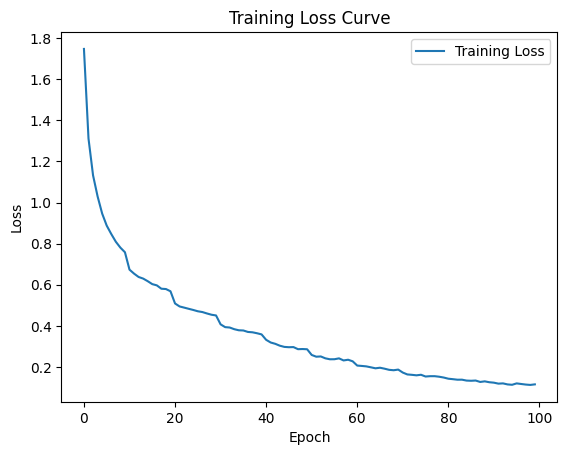

/home/grads/s/skpaul/Deep-ResNet-CIFAR-10/ResNet/Model.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_name, map_location=self.config.devi


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 923.60it/s]


Checkpoint 80 Test accuracy: 0.8330
Restored model parameters from models/resnet18_no_bn/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 883.63it/s]


Checkpoint 90 Test accuracy: 0.8380
Restored model parameters from models/resnet18_no_bn/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 900.96it/s]


Checkpoint 100 Test accuracy: 0.8454

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 895.19it/s]


Checkpoint 100 Test accuracy: 0.8368

--- Training with learning rate 0.01, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 1.662710 Duration 10.333 seconds.
Epoch 2 Loss 1.495275 Duration 10.171 seconds.
Epoch 3 Loss 1.195609 Duration 10.192 seconds.
Epoch 4 Loss 1.273158 Duration 10.254 seconds.
Epoch 5 Loss 1.069239 Duration 10.267 seconds.
Epoch 6 Loss 1.203536 Duration 10.215 seconds.
Epoch 7 Loss 0.996467 Duration 9.880 seconds.
Epoch 8 Loss 0.972214 Duration 10.095 seconds.
Epoch 9 Loss 1.042226 Duration 10.007 seconds.
Epoch 10 Loss 1.046651 Duration 9.867 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.896986 Duration 10.069 seconds.
Epoch 12 Loss 0.770283 Duration 10.037 seconds.
Epoch 13 Loss 1.013260 Duration 9.797 seconds.
Epoch 14 Loss 0.821909 Duration 9.968 seconds.
Epoch 15 Loss 0.914058 Duration 9.829 seconds.
Epoch 16 Loss 0.990866 Duration 10.226 seconds.
Epoch 17 Loss 0.772777 Duration 9.849 seconds.
Epoch 18 Loss 0.765801 Duration 10.10

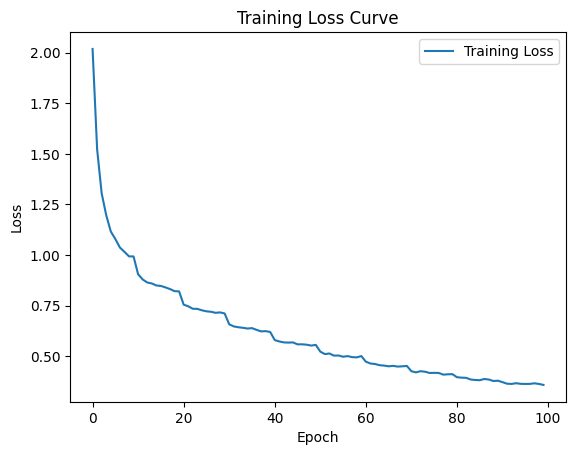


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 891.52it/s]


Checkpoint 80 Test accuracy: 0.8016
Restored model parameters from models/resnet18_no_bn/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 883.30it/s]


Checkpoint 90 Test accuracy: 0.8060
Restored model parameters from models/resnet18_no_bn/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 883.46it/s]


Checkpoint 100 Test accuracy: 0.8134

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 886.90it/s]


Checkpoint 100 Test accuracy: 0.8105

--- Training with learning rate 0.03, Residual: True, BatchNorm: False ---
### Training... ###
Epoch 1 Loss 1.944402 Duration 10.311 seconds.
Epoch 2 Loss 1.711124 Duration 10.265 seconds.
Epoch 3 Loss 1.339812 Duration 10.484 seconds.
Epoch 4 Loss 1.492732 Duration 10.300 seconds.
Epoch 5 Loss 1.330876 Duration 9.940 seconds.
Epoch 6 Loss 1.460463 Duration 10.350 seconds.
Epoch 7 Loss 1.392485 Duration 9.963 seconds.
Epoch 8 Loss 1.545137 Duration 10.182 seconds.
Epoch 9 Loss 1.245905 Duration 10.443 seconds.
Epoch 10 Loss 1.160064 Duration 10.191 seconds.
Checkpoint has been created.
Epoch 11 Loss 1.171553 Duration 10.308 seconds.
Epoch 12 Loss 1.166213 Duration 10.478 seconds.
Epoch 13 Loss 1.087600 Duration 10.375 seconds.
Epoch 14 Loss 1.197936 Duration 10.285 seconds.
Epoch 15 Loss 1.183339 Duration 10.124 seconds.
Epoch 16 Loss 1.158698 Duration 10.184 seconds.
Epoch 17 Loss 1.190701 Duration 10.199 seconds.
Epoch 18 Loss 1.440003 Duration 1

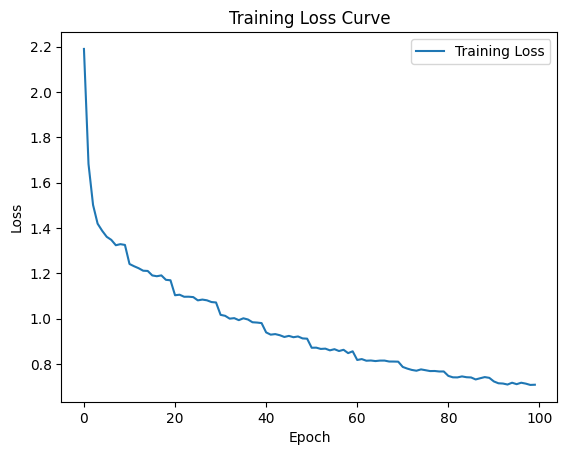


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 843.56it/s]


Checkpoint 80 Test accuracy: 0.7108
Restored model parameters from models/resnet18_no_bn/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 889.01it/s]


Checkpoint 90 Test accuracy: 0.7258
Restored model parameters from models/resnet18_no_bn/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 882.48it/s]


Checkpoint 100 Test accuracy: 0.7318

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_bn/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 882.44it/s]


Checkpoint 100 Test accuracy: 0.7159

--- Training with learning rate 0.003, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.263025 Duration 9.940 seconds.
Epoch 2 Loss 1.092176 Duration 10.729 seconds.
Epoch 3 Loss 1.333144 Duration 10.337 seconds.
Epoch 4 Loss 0.919361 Duration 10.341 seconds.
Epoch 5 Loss 0.990788 Duration 9.939 seconds.
Epoch 6 Loss 0.989026 Duration 9.830 seconds.
Epoch 7 Loss 0.830233 Duration 10.082 seconds.
Epoch 8 Loss 0.873594 Duration 10.000 seconds.
Epoch 9 Loss 0.797874 Duration 10.126 seconds.
Epoch 10 Loss 0.725255 Duration 10.286 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.804928 Duration 9.919 seconds.
Epoch 12 Loss 0.554461 Duration 10.134 seconds.
Epoch 13 Loss 0.768791 Duration 10.154 seconds.
Epoch 14 Loss 0.746103 Duration 10.208 seconds.
Epoch 15 Loss 0.712914 Duration 10.461 seconds.
Epoch 16 Loss 0.627964 Duration 10.072 seconds.
Epoch 17 Loss 0.707806 Duration 10.542 seconds.
Epoch 18 Loss 0.456524 Duration 9.

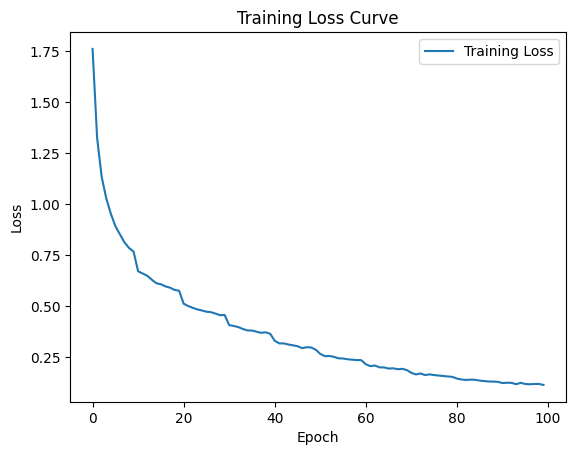


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 866.23it/s]


Checkpoint 80 Test accuracy: 0.8402
Restored model parameters from models/resnet18_no_residual/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 885.52it/s]


Checkpoint 90 Test accuracy: 0.8410
Restored model parameters from models/resnet18_no_residual/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 885.46it/s]


Checkpoint 100 Test accuracy: 0.8382

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 885.19it/s]


Checkpoint 100 Test accuracy: 0.8333

--- Training with learning rate 0.01, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.523310 Duration 10.007 seconds.
Epoch 2 Loss 1.340042 Duration 10.246 seconds.
Epoch 3 Loss 1.095615 Duration 10.460 seconds.
Epoch 4 Loss 1.110809 Duration 10.244 seconds.
Epoch 5 Loss 0.917761 Duration 10.406 seconds.
Epoch 6 Loss 1.205133 Duration 10.189 seconds.
Epoch 7 Loss 0.999702 Duration 10.372 seconds.
Epoch 8 Loss 1.036946 Duration 10.242 seconds.
Epoch 9 Loss 1.141690 Duration 9.895 seconds.
Epoch 10 Loss 0.685707 Duration 10.389 seconds.
Checkpoint has been created.
Epoch 11 Loss 1.118273 Duration 10.051 seconds.
Epoch 12 Loss 0.893365 Duration 10.103 seconds.
Epoch 13 Loss 0.846906 Duration 10.237 seconds.
Epoch 14 Loss 0.969068 Duration 10.291 seconds.
Epoch 15 Loss 0.822240 Duration 10.246 seconds.
Epoch 16 Loss 0.892608 Duration 10.093 seconds.
Epoch 17 Loss 0.835708 Duration 10.106 seconds.
Epoch 18 Loss 0.777927 Duration 

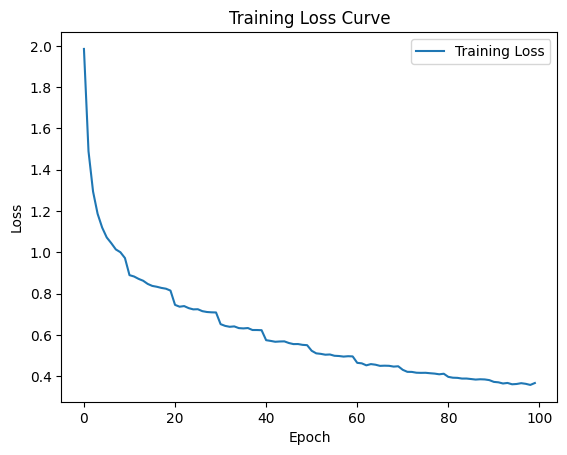


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 872.29it/s]


Checkpoint 80 Test accuracy: 0.8076
Restored model parameters from models/resnet18_no_residual/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 872.29it/s]


Checkpoint 90 Test accuracy: 0.8176
Restored model parameters from models/resnet18_no_residual/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 879.54it/s]


Checkpoint 100 Test accuracy: 0.8132

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 867.48it/s]


Checkpoint 100 Test accuracy: 0.8041

--- Training with learning rate 0.03, Residual: False, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.783512 Duration 10.326 seconds.
Epoch 2 Loss 1.590569 Duration 9.966 seconds.
Epoch 3 Loss 1.485899 Duration 10.099 seconds.
Epoch 4 Loss 1.475483 Duration 9.748 seconds.
Epoch 5 Loss 1.522832 Duration 9.984 seconds.
Epoch 6 Loss 1.248134 Duration 10.205 seconds.
Epoch 7 Loss 1.536191 Duration 10.128 seconds.
Epoch 8 Loss 1.217274 Duration 10.340 seconds.
Epoch 9 Loss 1.321041 Duration 9.924 seconds.
Epoch 10 Loss 1.311321 Duration 10.017 seconds.
Checkpoint has been created.
Epoch 11 Loss 1.234997 Duration 10.027 seconds.
Epoch 12 Loss 1.350428 Duration 9.851 seconds.
Epoch 13 Loss 1.166497 Duration 10.150 seconds.
Epoch 14 Loss 1.374326 Duration 10.148 seconds.
Epoch 15 Loss 1.095643 Duration 9.881 seconds.
Epoch 16 Loss 1.258880 Duration 10.459 seconds.
Epoch 17 Loss 1.204662 Duration 10.315 seconds.
Epoch 18 Loss 1.065779 Duration 10.38

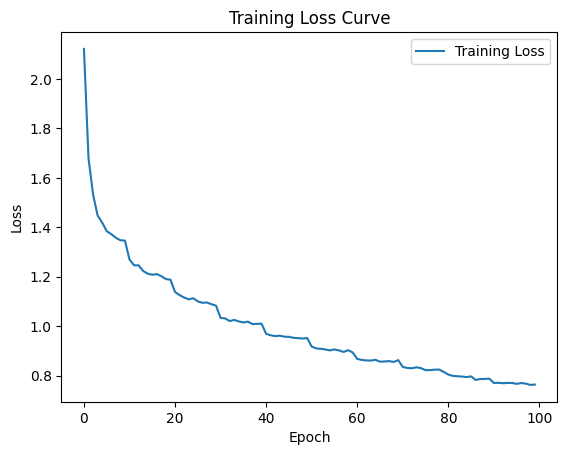


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 868.95it/s]


Checkpoint 80 Test accuracy: 0.6938
Restored model parameters from models/resnet18_no_residual/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 872.28it/s]


Checkpoint 90 Test accuracy: 0.7042
Restored model parameters from models/resnet18_no_residual/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 870.70it/s]


Checkpoint 100 Test accuracy: 0.7232

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18_no_residual/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 870.86it/s]


Checkpoint 100 Test accuracy: 0.7123

--- Training with learning rate 0.003, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.500610 Duration 10.192 seconds.
Epoch 2 Loss 1.163246 Duration 10.351 seconds.
Epoch 3 Loss 1.043125 Duration 10.278 seconds.
Epoch 4 Loss 0.868036 Duration 10.119 seconds.
Epoch 5 Loss 0.896828 Duration 10.291 seconds.
Epoch 6 Loss 0.821193 Duration 10.096 seconds.
Epoch 7 Loss 0.788602 Duration 10.544 seconds.
Epoch 8 Loss 0.831245 Duration 10.576 seconds.
Epoch 9 Loss 0.759124 Duration 10.314 seconds.
Epoch 10 Loss 0.786293 Duration 10.339 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.701109 Duration 9.799 seconds.
Epoch 12 Loss 0.719460 Duration 10.281 seconds.
Epoch 13 Loss 0.644605 Duration 10.342 seconds.
Epoch 14 Loss 0.643829 Duration 10.527 seconds.
Epoch 15 Loss 0.683544 Duration 10.670 seconds.
Epoch 16 Loss 0.634724 Duration 10.927 seconds.
Epoch 17 Loss 0.746671 Duration 10.752 seconds.
Epoch 18 Loss 0.583692 Duration 

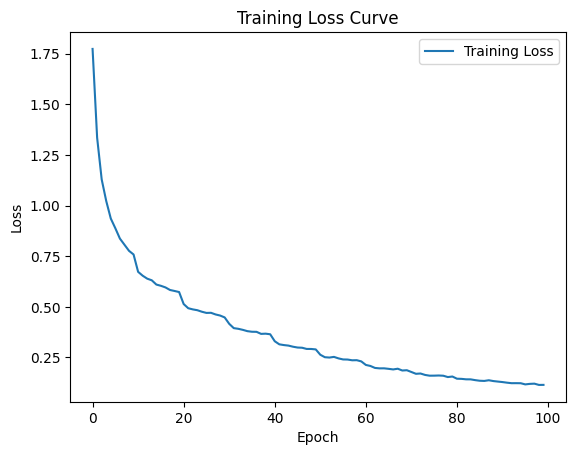


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.003/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 860.14it/s]


Checkpoint 80 Test accuracy: 0.8364
Restored model parameters from models/resnet18/0.003/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 868.09it/s]


Checkpoint 90 Test accuracy: 0.8440
Restored model parameters from models/resnet18/0.003/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 881.14it/s]


Checkpoint 100 Test accuracy: 0.8428

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.003/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 895.38it/s]


Checkpoint 100 Test accuracy: 0.8360

--- Training with learning rate 0.01, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.686869 Duration 9.813 seconds.
Epoch 2 Loss 1.268084 Duration 10.212 seconds.
Epoch 3 Loss 1.210758 Duration 9.748 seconds.
Epoch 4 Loss 1.130830 Duration 9.926 seconds.
Epoch 5 Loss 1.023112 Duration 10.584 seconds.
Epoch 6 Loss 1.088472 Duration 10.084 seconds.
Epoch 7 Loss 1.131561 Duration 10.262 seconds.
Epoch 8 Loss 0.992606 Duration 10.424 seconds.
Epoch 9 Loss 0.958923 Duration 10.011 seconds.
Epoch 10 Loss 0.888164 Duration 10.313 seconds.
Checkpoint has been created.
Epoch 11 Loss 0.949131 Duration 10.662 seconds.
Epoch 12 Loss 0.889735 Duration 10.620 seconds.
Epoch 13 Loss 0.810158 Duration 10.153 seconds.
Epoch 14 Loss 0.890933 Duration 10.179 seconds.
Epoch 15 Loss 0.855328 Duration 10.016 seconds.
Epoch 16 Loss 0.780549 Duration 10.119 seconds.
Epoch 17 Loss 0.919180 Duration 10.323 seconds.
Epoch 18 Loss 0.825957 Duration 9.7

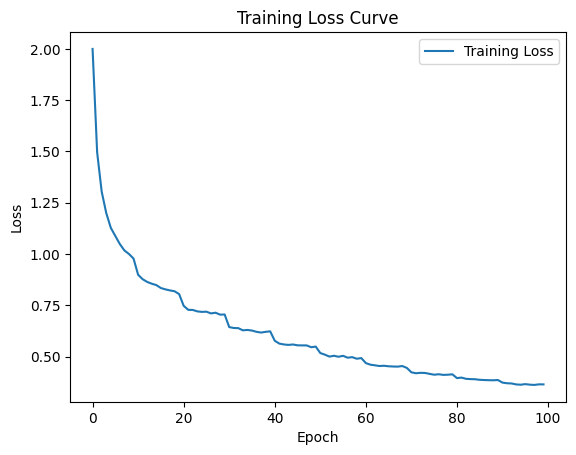


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.01/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 861.29it/s]


Checkpoint 80 Test accuracy: 0.7896
Restored model parameters from models/resnet18/0.01/model-90.ckpt


100%|██████████| 5000/5000 [00:06<00:00, 806.82it/s]


Checkpoint 90 Test accuracy: 0.8104
Restored model parameters from models/resnet18/0.01/model-100.ckpt


100%|██████████| 5000/5000 [00:06<00:00, 794.64it/s]


Checkpoint 100 Test accuracy: 0.8154

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.01/model-100.ckpt


100%|██████████| 10000/10000 [00:12<00:00, 796.97it/s]


Checkpoint 100 Test accuracy: 0.8016

--- Training with learning rate 0.03, Residual: True, BatchNorm: True ---
### Training... ###
Epoch 1 Loss 1.740338 Duration 10.804 seconds.
Epoch 2 Loss 1.684335 Duration 10.193 seconds.
Epoch 3 Loss 1.373292 Duration 10.032 seconds.
Epoch 4 Loss 1.430901 Duration 9.996 seconds.
Epoch 5 Loss 1.426983 Duration 10.200 seconds.
Epoch 6 Loss 1.278743 Duration 10.308 seconds.
Epoch 7 Loss 1.518681 Duration 9.893 seconds.
Epoch 8 Loss 1.327973 Duration 10.118 seconds.
Epoch 9 Loss 1.206445 Duration 10.421 seconds.
Epoch 10 Loss 1.453645 Duration 10.572 seconds.
Checkpoint has been created.
Epoch 11 Loss 1.289356 Duration 10.318 seconds.
Epoch 12 Loss 1.227545 Duration 10.519 seconds.
Epoch 13 Loss 1.177400 Duration 10.581 seconds.
Epoch 14 Loss 1.231234 Duration 10.389 seconds.
Epoch 15 Loss 1.204378 Duration 10.123 seconds.
Epoch 16 Loss 1.061995 Duration 9.939 seconds.
Epoch 17 Loss 1.034298 Duration 9.826 seconds.
Epoch 18 Loss 1.081295 Duration 10.0

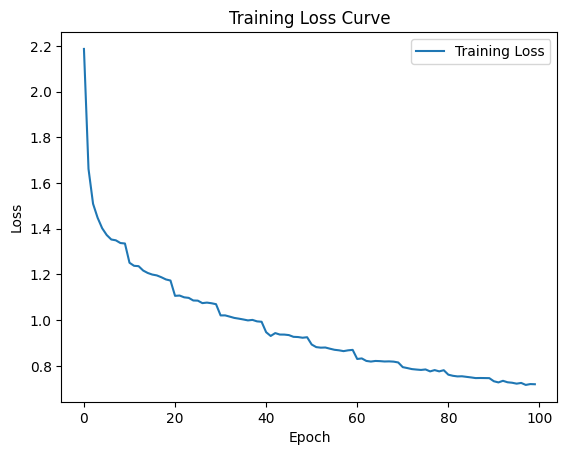


--- Validation ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.03/model-80.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 868.89it/s]


Checkpoint 80 Test accuracy: 0.7130
Restored model parameters from models/resnet18/0.03/model-90.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 889.54it/s]


Checkpoint 90 Test accuracy: 0.7200
Restored model parameters from models/resnet18/0.03/model-100.ckpt


100%|██████████| 5000/5000 [00:05<00:00, 883.59it/s]


Checkpoint 100 Test accuracy: 0.7304

--- Test ---
### Test or Validation ###
Restored model parameters from models/resnet18/0.03/model-100.ckpt


100%|██████████| 10000/10000 [00:11<00:00, 879.79it/s]

Checkpoint 100 Test accuracy: 0.7226


In [2]:
# Device setup (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Directory for saving models
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Define configurations for ResNet variations
configs = [
    {"use_residual": True, "use_bn": False, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_bn")},
    {"use_residual": False, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18_no_residual")},
    {"use_residual": True, "use_bn": True, "modeldir": os.path.join(MODEL_DIR, "resnet18")},
]

# Define learning rates to test
learning_rates = [0.003, 0.01, 0.03]

# Run experiments for each configuration and learning rate
for config in configs:
    for lr in learning_rates:
        lr_modeldir = os.path.join(config["modeldir"], str(lr))
        os.makedirs(lr_modeldir, exist_ok=True)
        run_experiment(
            batch_size=128,
            save_interval=10,
            weight_decay=2e-4,
            learning_rate=lr,
            modeldir=lr_modeldir,
            use_residual=config["use_residual"],
            use_bn=config["use_bn"],
            device=device
        )
